# Analysis of Best Javanese Classifier

**Best Pretrained Model:** [Indonesian GPT-2](https://huggingface.co/flax-community/gpt2-small-indonesian)

In [13]:
from src.train import run_experiments
from src.dataset import construct_datasets
from src.classifier import Classifier
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('fivethirtyeight')
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from typing import Tuple
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, logging
logging.set_verbosity(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

## Train Indonesian GPT-2 Classifier

In [86]:
# Hyperparameters
data_dir = 'data/fold5/'
model_name = 'flax-community/gpt2-small-indonesian'
layers_to_unfreeze = 1
pooling = 'MLP'
classifier_hidden_size = 64
n_experiments = 1
n_epochs = 4
patience = 4
batch_size = 16
verbose = True

# Train classifier
classifier, _, _ = run_experiments(data_dir, model_name, layers_to_unfreeze, pooling,
                                   classifier_hidden_size, n_experiments, n_epochs,
                                   patience, batch_size, verbose)

Training classifier 1


100%|██████████| 22/22 [00:01<00:00, 11.91it/s]


F1 Scores: [0.7119, 0.8663, 0.0]
Micro: 0.8045977011494253
Macro: 0.5260439572831738
Epoch 1, Train Loss: 0.6993, Dev Accuracy: 0.8046, Dev F1: 0.7820


100%|██████████| 22/22 [00:01<00:00, 19.02it/s]


F1 Scores: [0.7937, 0.8996, 0.5517]
Micro: 0.8563218390804598
Macro: 0.748318840513329
Epoch 2, Train Loss: 0.3838, Dev Accuracy: 0.8563, Dev F1: 0.8545


100%|██████████| 22/22 [00:01<00:00, 14.25it/s]


F1 Scores: [0.8105, 0.9079, 0.5714]
Micro: 0.867816091954023
Macro: 0.7633015593376747
Epoch 3, Train Loss: 0.2184, Dev Accuracy: 0.8678, Dev F1: 0.8656


100%|██████████| 22/22 [00:01<00:00, 20.64it/s]


F1 Scores: [0.791, 0.8898, 0.5263]
Micro: 0.8448275862068967
Macro: 0.7356963770879917
Epoch 4, Train Loss: 0.1293, Dev Accuracy: 0.8448, Dev F1: 0.8457


100%|██████████| 22/22 [00:01<00:00, 20.18it/s]

F1 Scores: [0.809, 0.8954, 0.5789]
Micro: 0.8559077809798271
Macro: 0.7611112073352485
Test Accuracy: 0.8559, Test F1: 0.8577

Trainable parameters: 7188548
Dev Set F1
    Mean: 0.8457
    Std: 0.0000
Best Model F1: 0.8577


## Evaluate Classifier on Dev and Test Sets

In [87]:
def evaluate_classifier(dataloader1: DataLoader, dataloader2: DataLoader, tokenizer: AutoTokenizer,
                        classifier: Classifier) -> Tuple[float, float, np.ndarray, pd.DataFrame]:
    """ Evaluates the classifier.

    Parameters
    ----------
    dataloader1: Data loader from HateSpeechDataset class
    dataloader2: Data loader from HateSpeechDataset class
    classifier: Instance of Classifier class

    Returns
    -------
    pred_df: DataFrame containing true and predicted labels
    """
    classifier.eval()
    true_labels = []
    pred_labels = []
    sentences = []
    with torch.no_grad():
        for dataloader in [dataloader1, dataloader2]:
            for labels, batch in dataloader:
                outputs = classifier(batch)
                predictions = torch.argmax(outputs, dim=1)
                true_labels.extend(labels.cpu().numpy())
                pred_labels.extend(predictions.cpu().numpy())
                input_ids = batch['input_ids']
                decoded_sentences = [tokenizer.decode(ids, skip_special_tokens=True)
                                    for ids in input_ids]
                sentences.extend(decoded_sentences)
    pred_df = pd.DataFrame({
        'sentence': sentences,
        'target': true_labels,
        'predicted': pred_labels
    })
    return pred_df

In [88]:
# Load tokenizer and dataloaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(model_name)
if 'gpt2' in model_name:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.model_max_length = 1024
datasets, dataloaders = construct_datasets(
    prefix=data_dir,
    batch_size=batch_size,
    tokenizer=tokenizer,
    device=device)

# Evaluate classifier
pred_df = evaluate_classifier(dataloaders['dev'], dataloaders['test'], classifier, tokenizer)
os.makedirs('results', exist_ok=True)
pred_df.to_csv('results/predictions.csv', index=False)
misclassified = pred_df[pred_df['target'] != pred_df['predicted']]
misclassified.to_csv('results/misclassified_predictions.csv', index=False)

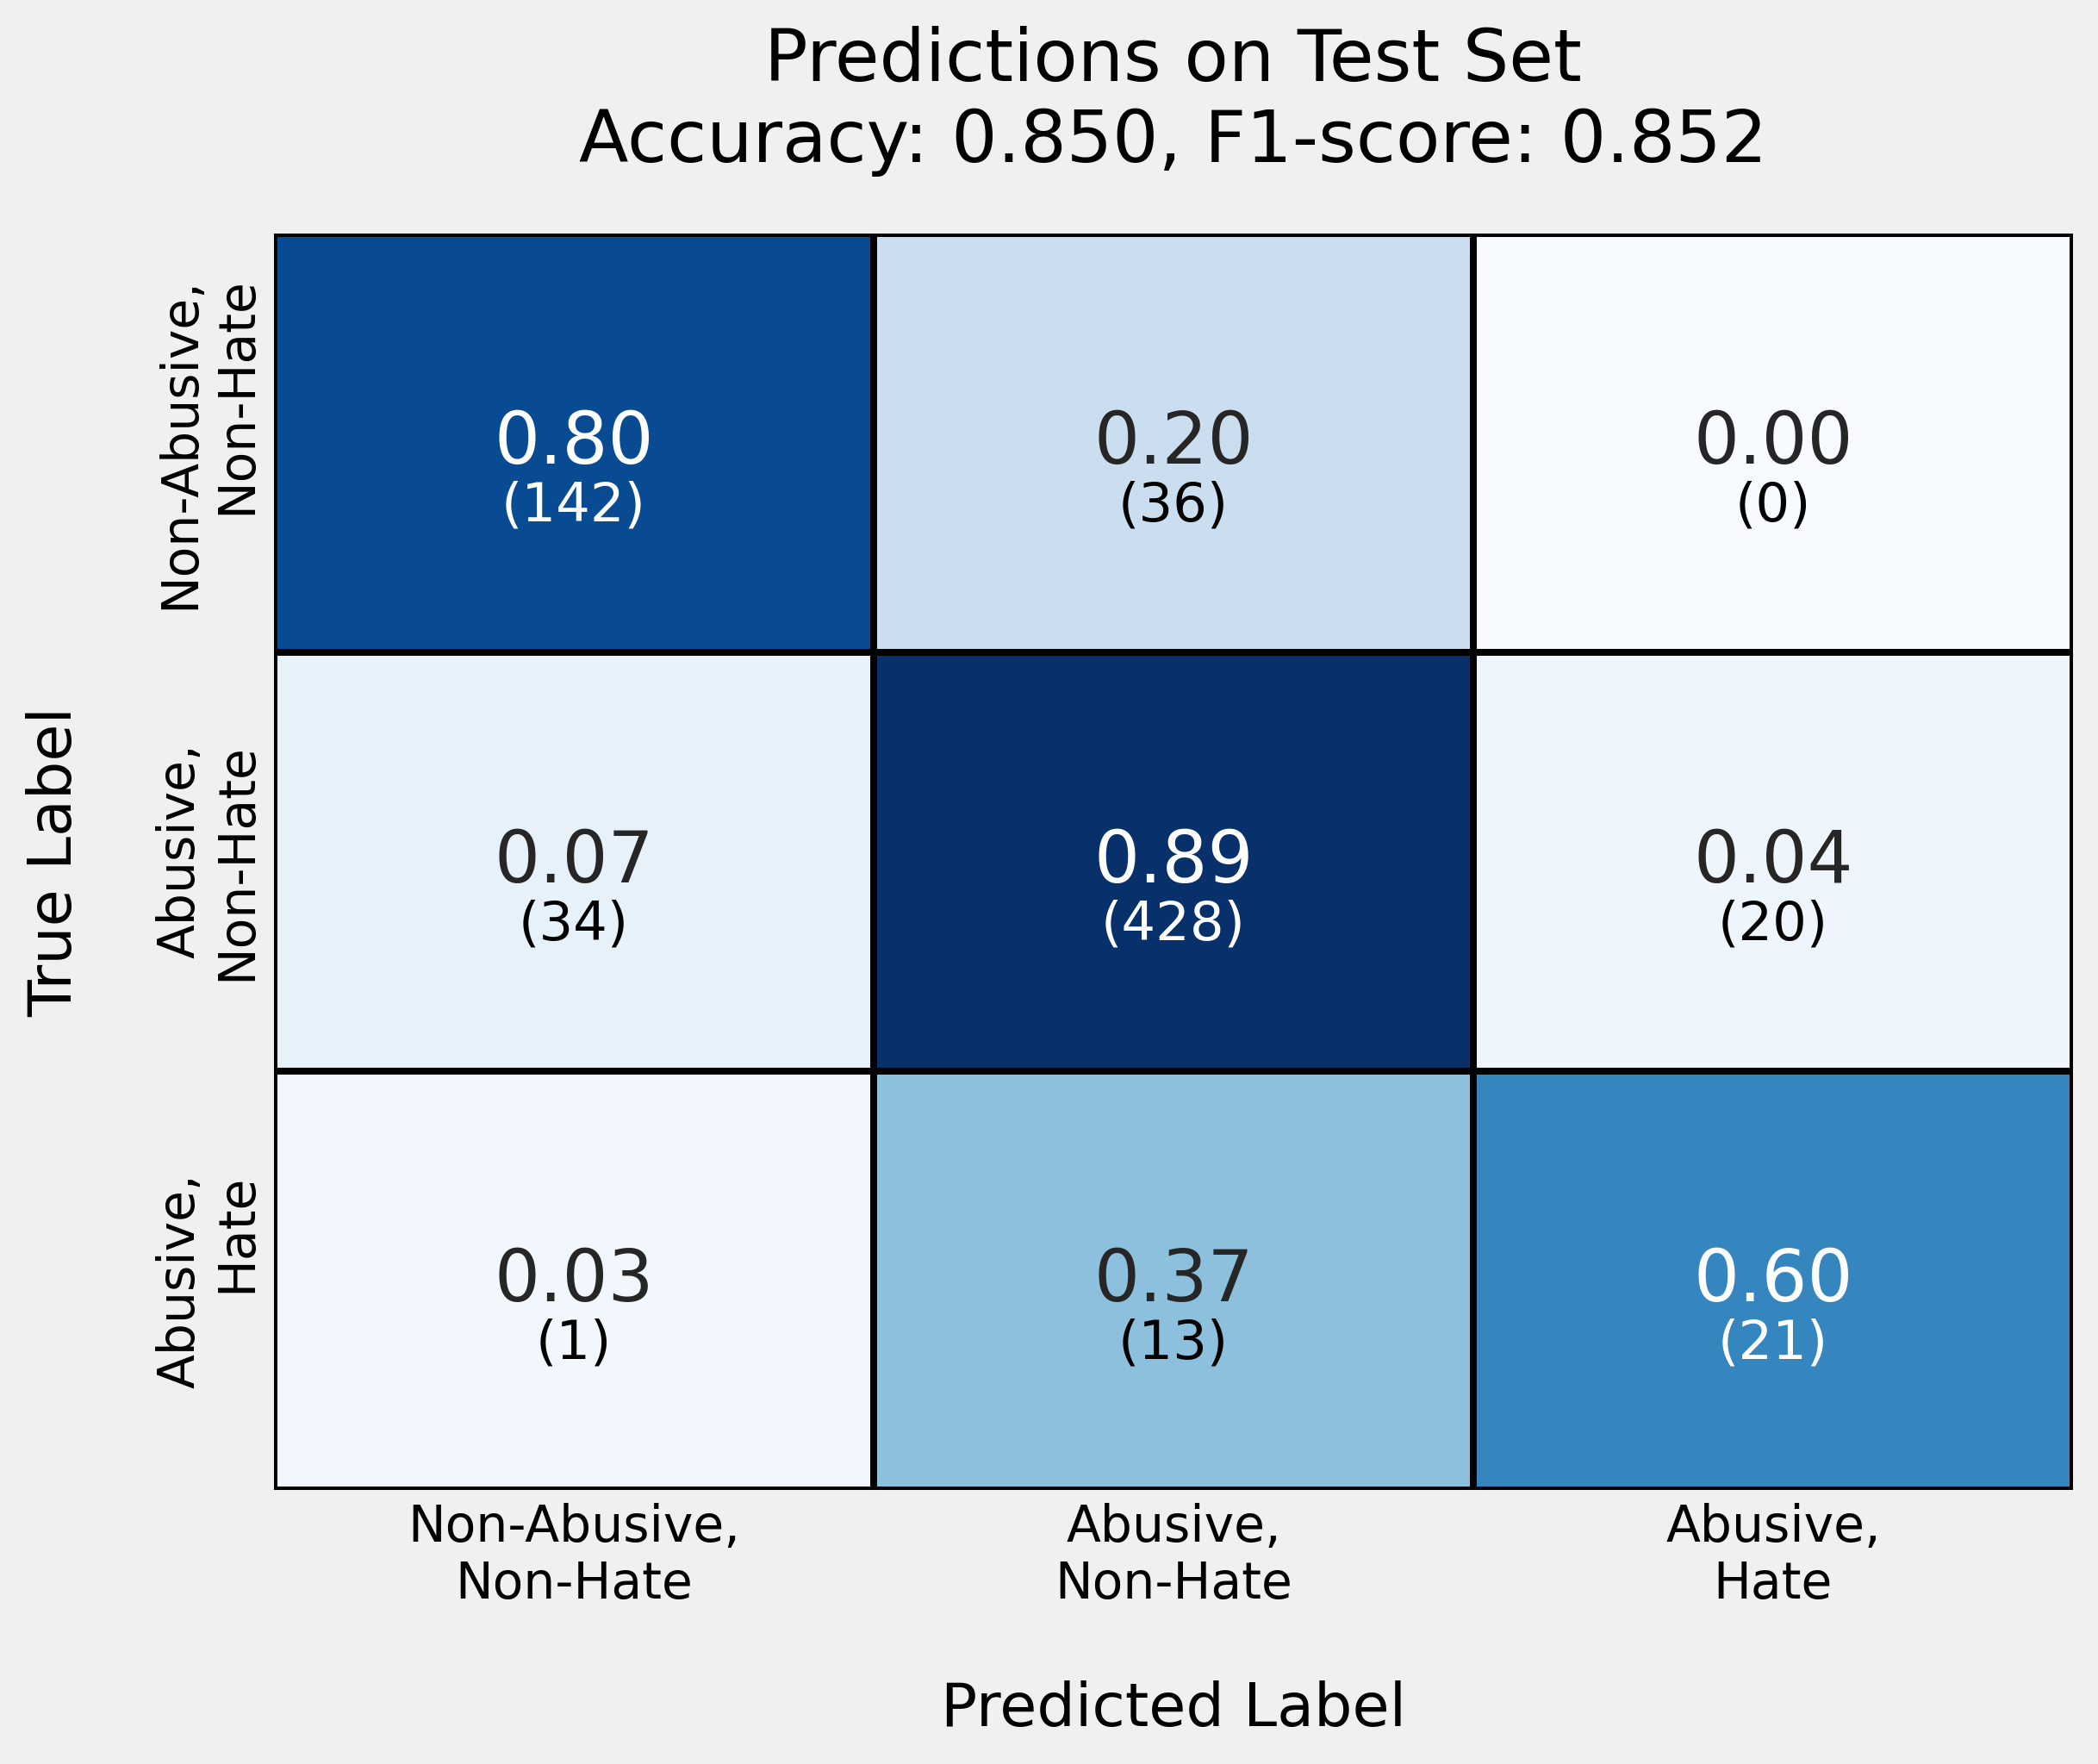

In [7]:
# Make confusion matrix
pred_df = pd.read_csv('results/predictions.csv')
true_labels = pred_df['target']
pred_labels = pred_df['predicted']
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap
plt.figure(figsize=(8, 6))
class_names = ['Non-Abusive,\nNon-Hate', 'Abusive,\nNon-Hate', 'Abusive,\nHate']
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, annot_kws={'size': 20},
            cbar=False, linewidths=1.5, linecolor='black')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        count_text = f'({cm[i, j]})'
        if i == j:
            plt.text(j + 0.5, i + 0.65, count_text, ha='center', va='center', color='white', fontsize=15)
        else:
            plt.text(j + 0.5, i + 0.65, count_text, ha='center', va='center', color='black', fontsize=15)
plt.title(f'Predictions on Test Set\nAccuracy: {accuracy:.3f}, F1-score: {f1:.3f}', pad=20)
plt.ylabel('True Label', labelpad=20)
plt.xlabel('Predicted Label', labelpad=20)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/confusion_matrix.png', bbox_inches='tight', transparent=True)

## Visualize Attention MLP and Classifier Architecture

In [24]:
class TestAttentionMLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(TestAttentionMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1))

    def forward(self, token_embeddings: torch.Tensor) -> torch.Tensor:
        attention_logits = self.mlp(token_embeddings)  # [B, L, 1]
        attention_weights = F.softmax(attention_logits, dim=1)  # [B, L, 1]
        pooled_representation = torch.sum(attention_weights * token_embeddings, dim=1)  # [B, E]
        return pooled_representation


class TestClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes: int):
        super(TestClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(768, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes))

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        logits = self.classifier(features[:, 0, :])
        return logits

print(summary(TestAttentionMLP(768, 64), (16, 40, 768)))
print(summary(TestClassifier(64, 3), (16, 40, 768)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 16, 40, 64]          49,216
              ReLU-2           [-1, 16, 40, 64]               0
            Linear-3            [-1, 16, 40, 1]              65
Total params: 49,281
Trainable params: 49,281
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.88
Forward/backward pass size (MB): 0.63
Params size (MB): 0.19
Estimated Total Size (MB): 2.69
----------------------------------------------------------------
None
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 40, 64]          49,216
              ReLU-2               [-1, 40, 64]               0
            Linear-3               [-1, 40, 32]           2,080
              ReLU-4               [-1